# Privacy-preserving K-Means Clustering over Vertically Partitioned Data

I implemented [Privacy-Preserving K-Means Clustering over Vertically Partitioned Data](https://dl.acm.org/doi/pdf/10.1145/956750.956776).

The key idea of this paper is to cluster data that is vertically partitioned into different parties. Each party contain different attributes for a common set of entities. Each party learns the cluster of each entity, but learns nothing about the attributes at other parties. 

In [1]:
import numpy as np
from random import *
from math import *
from phe import paillier

## Data generation

The following private preserving K-Means clustering can be applied for multi-parties, each having different numbers of attributes. I generated a dataset and divided it into different subsets which contain different attributes for a common set of entities. 

In [2]:
def datagen(numProcs=5, numClusters=4, numPoints=10, dim=1):
    data = []
    label = []
    for cluster in range(numClusters):
        procData = []
        mean = [randint(1,dataRange) for i in range(dim)]
        var = sqrt(dim)*dataRange/numProcs**(3)
        variance = lambda : triangular(0.5*var, 1.5*var)
        for i in range(int(numPoints/numClusters)):
            data.append([int(gauss(mean[j],variance())) for j in range(dim)])
            label.append(cluster)
    cluster_data = np.array(data)
    result = [[] for _ in range(numProcs)]
    data = np.array(data)
    print(data.shape)
    for idx, attribute in enumerate(list(range(dim))):
        procNumber = randint(0,numProcs-1)
        result[procNumber].append(list(data[:,attribute]))
    
    for procNumber in range(numProcs):
        result[procNumber] = np.transpose(np.array(result[procNumber]))
        
    return cluster_data, label, result

numProcs = 5
numClusters = 4 
numPoints = 40
dim = 20
dataRange = 50
assert numPoints % numClusters == 0
assert dim >= numProcs
cluster_data, label, data = datagen(numProcs, numClusters, numPoints, dim)
#print(cluster_data, label, data)

(40, 20)


## Visualize high-dimensional data

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def draw(cluster_data, label):
    plt.plot()
    RS = 2612
    digits_proj = TSNE(random_state=RS).fit_transform(cluster_data)
    plt.scatter(digits_proj[:, 0], digits_proj[:, 1], c=label)
    plt.show()

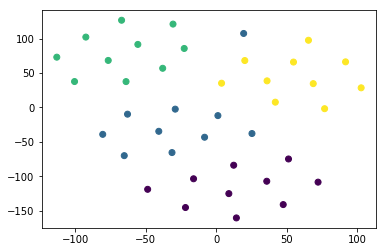

In [4]:
draw(cluster_data, label)

## Party

Here I defined the class party and sub-classes Party_Slave and Party_Master. Each party obtain the partitioned data(dataPoints), and a local center of the partitioned data(uij). Each party learns the cluster of each entity, but learns nothing about the attributes at other parites. Notice the master party will generates a random vector i (see function genV) for each site i and hold it for futher computation.  

In [5]:
class Party():
    def __init__(self, k, data):
        self.dataPoints = []
        self.d = data.shape[1]
        for val in data:
            self.dataPoints.append(val)
        self.dataPoints = np.array(self.dataPoints)
        self.k = k
        tmp = numPoints/self.k
        self.uij = self.dataPoints[[randint(i*tmp, (1+i)*tmp-1) for i in range(self.k)]]
        self.uij2 = None
        
    def updateMeans(self):
        self.uij = self.uij2
        self.uij2 = None
    
    def calX(self, p):
        self.x = [np.sqrt(np.sum(np.square(self.dataPoints[p] - b))) for b in self.uij]
    
    def __str__(self):
        return str(self.uij)

    def getDims(self):
        return self.d
    
    def encode_each_item(self, x, pubkey):
        return [pubkey.encrypt(x[i]) for i in range(len(x))]
    
    def decode_each_item(self, x, private_key):
        return [private_key.decrypt(x[i]) for i in range(len(x))]
    
    def sendT(self):
        return self.t
    
    def sumT(self, t):
        self.t = np.array([a+b for a,b in zip(self.t, t)])
        
    def calY(self, t):
        self.y = np.array([a+b for a,b in zip(self.t, t)])
        
    def calMeans(self, reset_cluster):
        self.uij2 = [np.average(self.dataPoints[reset_cluster[k]], 0) for k in range(numClusters)]
        self.uij2 = np.nan_to_num(self.uij2)
        
    def calD(self):
        self.d = sum([np.sqrt(np.sum(np.square(a - b))) for a,b in zip(self.uij2, self.uij)])
    
    def sendP(self):
        return (self.m + self.d) % numPoints 
    
    def updateP(self, m, israndom = False):
        self.m = randrange(0,numPoints*3) if israndom else m 
        
    def sumDandP(self):
        self.m += self.d
    
class Party_Slave(Party):
    def __init__(self, k, data):  
        Party.__init__(self, k, data)
        
    def genKey(self):
        (self.pubkey, self.privkey) = paillier.generate_paillier_keypair()
        return self.pubkey
        
    def encode(self):
        crypt_text = self.encode_each_item(self.x, self.pubkey)
        return crypt_text
    
    def decode(self, crypt_text):
        self.t = self.decode_each_item(crypt_text, self.privkey)

class Party_Master(Party):
    def __init__(self, k, data):  
        Party.__init__(self, k, data)
        
    def genV(self, r, n = 10):
        self.v = np.zeros([r,self.k])
        for i in range(self.k):
            partSum_i = 0
            for j in range(1, r):
                self.v[j][i] = random() 
                partSum_i = (partSum_i + self.v[j][i]) % n
            self.v[0][i] = -(partSum_i % n)

    def genPermutation(self):
        self.pi = np.random.permutation(self.k)
    
    def sendKeyAndGetT(self, x, pubkey, _id):
        encode_v = self.encode_each_item(self.v[_id], pubkey)
        t = [a+b for a,b in zip(x, encode_v)]
        return np.array(t)[self.pi]
    
    def permuteT(self, _id):
        self.t = (self.x + self.v[_id])[self.pi]
        
    def inversePi(self, minimal):
        return self.pi[minimal] 

## closest cluster 
Find minimum distance cluster. 

We securely find the closest cluster. We calculated the distance to each cluster for each data points. This calculation was done inside each party and they will hold their distance vectors (X). 

First, The master party generates a random vector (V) for each party. Each slave party will generate  a  public-private keypair for a homomorphic encryption scheme. And each slave party (party i) send the encoded distance vector (x_i) and public key to the master party. The master party encoded the random vector (v_i) , calculated the sum of the encoded distance vector (x_i) and the encoded random vector (v_i),  permuted the result, and finally send it back to the slave party. The slave party decode the final result. Now, for each slave party, they have the permuted sum (t_i) of the distance vector (x_i) and the random vector (v_i). It is secure because each slave party don't know the random vector and permutation vector. 

Next, all parties except two slave party (party 2 and party r) will send the permuted sum (t_i) to party r. So party r can calculate the sum (y) of all permuted sum except the result of party 2. 

Finally, between party 2 and party r, they will securely add and compare y and t_2 to find the minimal cluster. I simplified the secure_add_and_compare function. Notice, till now, the calulation is done on permuted data, so we need the master party to find the true value of the closet cluster. 


In [6]:
def closet_cluster(parties):
    parties[0].genV(numProcs)
    parties[0].genPermutation()
    parties[0].permuteT(0)
    for i in range(1, numProcs):
        add_and_permutation(parties, i)
    
    if debug:
        print(parties[0].v)
        print(parties[0].pi)
        for i in range(numProcs):
            print('x', parties[i].x)
            print('t', parties[i].t)
        print('\n') 
        
    for i in range(2, numProcs - 1):
        parties[numProcs - 1].sumT(parties[i].sendT())
    
    parties[numProcs - 1].calY(parties[0].sendT())
    
    if debug:
        print(parties[numProcs - 1].y + parties[1].t)
        sumx = np.zeros([numClusters])
        for i in range(numProcs):
            sumx += parties[i].x
        print(sumx)
        
    minimal = 0
    for j in range(1, numClusters):
        if (parties[numProcs-1].y[j] + parties[1].t[j] \
            < parties[numProcs-1].y[minimal] + parties[1].t[minimal]):
            minimal = j
    if debug:
        print(minimal, parties[0].pi, parties[0].inversePi(minimal), parties[0].pi[minimal])
    return parties[0].inversePi(minimal)
    

In [7]:
def add_and_permutation(parties, i):
    publickey = parties[i].genKey()
    encoded_x = parties[i].encode()
    encoded_t = parties[0].sendKeyAndGetT(encoded_x, publickey, i)
    parties[i].decode(encoded_t)

## checkThreshold
Find out if the new means are sufficiently close to old means. First, we calculated the distance of new clustering means and original means. Then, we securely sum the distance. Finally, we securely add and compare the threshold with the sum. I simplified the secure_add_and_compare function.

In [8]:
def checkThreshold(parties, th):
    for i in range(numProcs):
        parties[i].calD()
        if debug:
            print(parties[i].d)
    
    
    parties[0].updateP(0, israndom=True)
    for j in range(numProcs-1):
        parties[j+1].updateP(parties[j].sendP())
    
    parties[numProcs-1].sumDandP()
    
    th2 = th + numProcs
    if debug:
        print(parties[0].m, parties[numProcs-1].m)
        print(th2,(parties[numProcs-1].m - th2) % numPoints, (th2 - parties[numProcs-1].m) % numPoints)
    return (parties[numProcs-1].m - th2) % numPoints > (th2 - parties[numProcs-1].m) % numPoints 

## Privacy Preserving k-means clustering



First, I applied the algorithms on the generated dataset and displaied the clustering result.

In [9]:
debug = False
parties = [Party_Master(numClusters, data[0])]
for i in range(1, numProcs):
    parties.append(Party_Slave(numClusters, data[i]))

The algorithm contain 4 parts.

1. Initilization. Each party will initilize a center for each cluster. In our example, we have 4 cluster. So  each party holds four vectors as the center of clusters.
2. Find closet cluster. First, we calculate the distance to each cluster for each data points. This calculation are done inside each party and they will hold their distance vectors (X). Then, we will secure finding the closest cluster.
3. Calculate clustering means for  each party. Every point is assigned to the proper cluster. We securely find the cluster with the minimum distance for each point. Once these mappings are known, the local components of each cluster mean can be computed locally. After cluster all data points, we then calcuate the means of each cluster with attributes in each party. 
4. Check Threshold. Find out if the new means are sufficiently close to old means. 

In [10]:
def PPKMeans(th, parties):
    th = th
    while (True):
        result = []
        reset_cluster = [[] for i in range(numClusters)]
        if parties[0].uij2 is not None:
            print('updating means')
            for j in range(numProcs):
                parties[j].updateMeans()
                
        for g in range(numPoints):
            for j in range(numProcs):
                parties[j].calX(g)
                
            minimal = closet_cluster(parties)
            if debug:
                print(g, minimal)
            reset_cluster[minimal].append(g)
            result.append(minimal)
            
            
                
        for j in range(numProcs):
            parties[j].calMeans(reset_cluster)
        
        if debug:
            print(parties[j].uij, parties[j].uij2)
        
        if (checkThreshold(parties, th)):
            return result
    

In [11]:
reset_cluster = PPKMeans(10, parties)

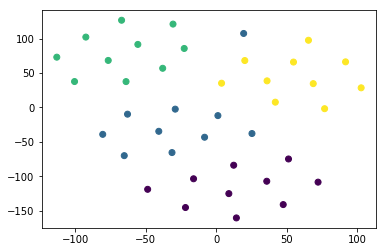

In [12]:
draw(cluster_data, reset_cluster)

## SCADI [dataset](https://archive.ics.uci.edu/ml/datasets/SCADI)

In [13]:
import pandas as pd
data = pd.read_csv('SCADI/SCADI.csv').values
numProcs = 10
label = pd.factorize(data[:,-1])[0].astype(np.uint16)
numClusters = len(set(label))
numPoints = data.shape[0]
dim = data.shape[1]-1
#dataRange = 50
assert numPoints % numClusters == 0
assert dim >= numProcs
result = [[] for _ in range(numProcs)]
data = data[:,:-1]
print(data.shape)

for idx, attribute in enumerate(list(range(dim))):
    procNumber = randint(0,numProcs-1)
    result[procNumber].append(list(data[:,attribute]))

for procNumber in range(numProcs):
    result[procNumber] = np.transpose(np.array(result[procNumber]))


(70, 205)


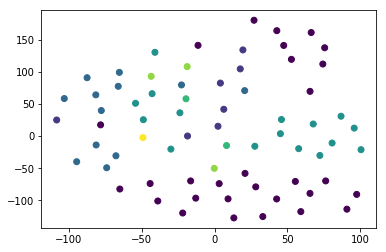

In [14]:
draw(data, label)

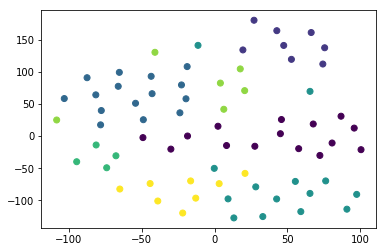

In [15]:
from sklearn.cluster import KMeans
new_labels = KMeans(n_clusters=numClusters).fit_predict(data)
draw(data,new_labels)

In [16]:
parties = [Party_Master(numClusters, result[0])]
for i in range(1, numProcs):
    parties.append(Party_Slave(numClusters, result[i]))

In [17]:
reset_cluster = PPKMeans(3, parties)

updating means


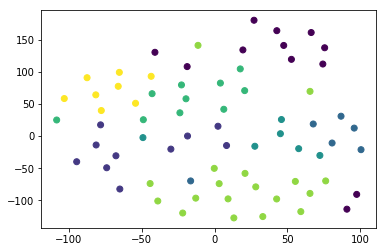

In [18]:
draw(data,reset_cluster)